In [1]:
import os   
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['MPLBACKEND'] = 'TKAgg'

import pickle
import numpy as np
import pandas as pd
import matplotlib
import math
from datetime import date

import jax
import jax.numpy as jnp

from archdfa_gen_diffpop import ARCHDFA

import arviz as az
import matplotlib.pyplot as plt
from DM_CBB_new import dm_test
from DM_CBB_new import CBB_test
from DM_CBB_new import stochastic_function
from DM_CBB_new import QS_Kernel
from DM_CBB_new import HAC_Variance


%matplotlib inline


/Users/dongahkim/anaconda3/envs/forecastskill/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load actual data

In [3]:
os.chdir("/Users/dongahkim/Creative Cloud Files/epi/comparing-forecasting-performance")
os.getcwd()

'/Users/dongahkim/Creative Cloud Files/epi/comparing-forecasting-performance'

In [4]:
data1 = "CU_select"
data2 = "USC_SI_kJalpha"
mypath = 'Data_description/diff_'+data1+'_'+data2+'.csv'
df = pd.read_csv(mypath)
df

,Unnamed: 0,abbreviation,location,reference_date,forecast_date.x,forecast_date.y,target_end_date.x,target_end_date.y,relative_horizon,diff,diff_pop
0,1,DE,10,2020-11-23,2020-11-22,2020-11-22,2020-11-24,2020-11-24,1,13.404530,1.376569
1,2,DE,10,2020-11-23,2020-11-22,2020-11-22,2020-12-03,2020-12-03,10,14.799369,1.519811
2,3,DE,10,2020-11-23,2020-11-22,2020-11-22,2020-12-04,2020-12-04,11,18.293403,1.878628
3,4,DE,10,2020-11-23,2020-11-22,2020-11-22,2020-12-05,2020-12-05,12,20.114239,2.065617
4,5,DE,10,2020-11-23,2020-11-22,2020-11-22,2020-12-06,2020-12-06,13,17.063712,1.752346
...,...,...,...,...,...,...,...,...,...,...,...
47071,47072,WY,56,2022-08-01,2022-07-31,2022-07-31,2022-08-02,2022-08-02,1,-0.098277,-0.016981
47072,47073,WY,56,2022-08-01,2022-07-31,2022-07-31,2022-08-03,2022-08-03,2,0.931241,0.160903
47073,47074,WY,56,2022-08-01,2022-07-31,2022-07-31,2022-08-04,2022-08-04,3,0.595620,0.102913
47074,47075,WY,56,2022-08-01,2022-07-31,2022-07-31,2022-08-05,2022-08-05,4,0.995827,0.172062


In [5]:
# Load the loss difference value of two data you want to compare
from itertools import combinations

def loaddata(data1, data2, val):
    mypath = 'Data_description/diff_'+data1+'_'+data2+'.csv'
    df = pd.read_csv(mypath)
    lix = pd.MultiIndex.from_product([np.unique(df.location), np.unique(df.relative_horizon)])
    df_pivot = (df.pivot_table(val, 'reference_date', ['location', 'relative_horizon'], aggfunc='first')).reindex(lix, axis=1)
    mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())
    return mydf

mydata =loaddata("CU_select", "USC_SI_kJalpha", "diff_pop")
print(mydata.shape)
print(mydata[0,0,:])

mydata1 =loaddata("CU_select", "USC_SI_kJalpha", "diff")
print(mydata1.shape)
print(mydata1[0,0,:])

datalist = ["COVIDhub_4_week_ensemble", "COVIDhub_baseline", "CU_select", "GT_DeepCOVID", "JHUAPL_Bucky", "USC_SI_kJalpha"]

for combo in combinations(datalist, 2):  # 2 for pairs, 3 for triplets, etc
    mydata =loaddata(combo[0], combo[1], "diff_pop")
    print(mydata.shape)

(85, 43, 13)
[1.3765687  1.7010101  0.93842864 1.6868565  1.6304353  1.6048557
 2.1225812  1.5595199  1.5377305  1.5198107  1.8786279  2.0656176
 1.7523457 ]
(85, 43, 13)
[13.40453   16.563824   9.13808   16.426     15.876592  15.627506
 20.668932  15.186044  14.9738655 14.79937   18.293402  20.114239
 17.063711 ]
(87, 43, 14)
(84, 43, 13)
(87, 42, 14)
(87, 43, 14)
(86, 43, 13)
(84, 43, 13)
(87, 42, 14)
(87, 43, 14)
(86, 43, 13)
(93, 42, 13)
(93, 43, 13)
(85, 43, 13)
(96, 42, 14)
(88, 42, 13)
(88, 43, 13)


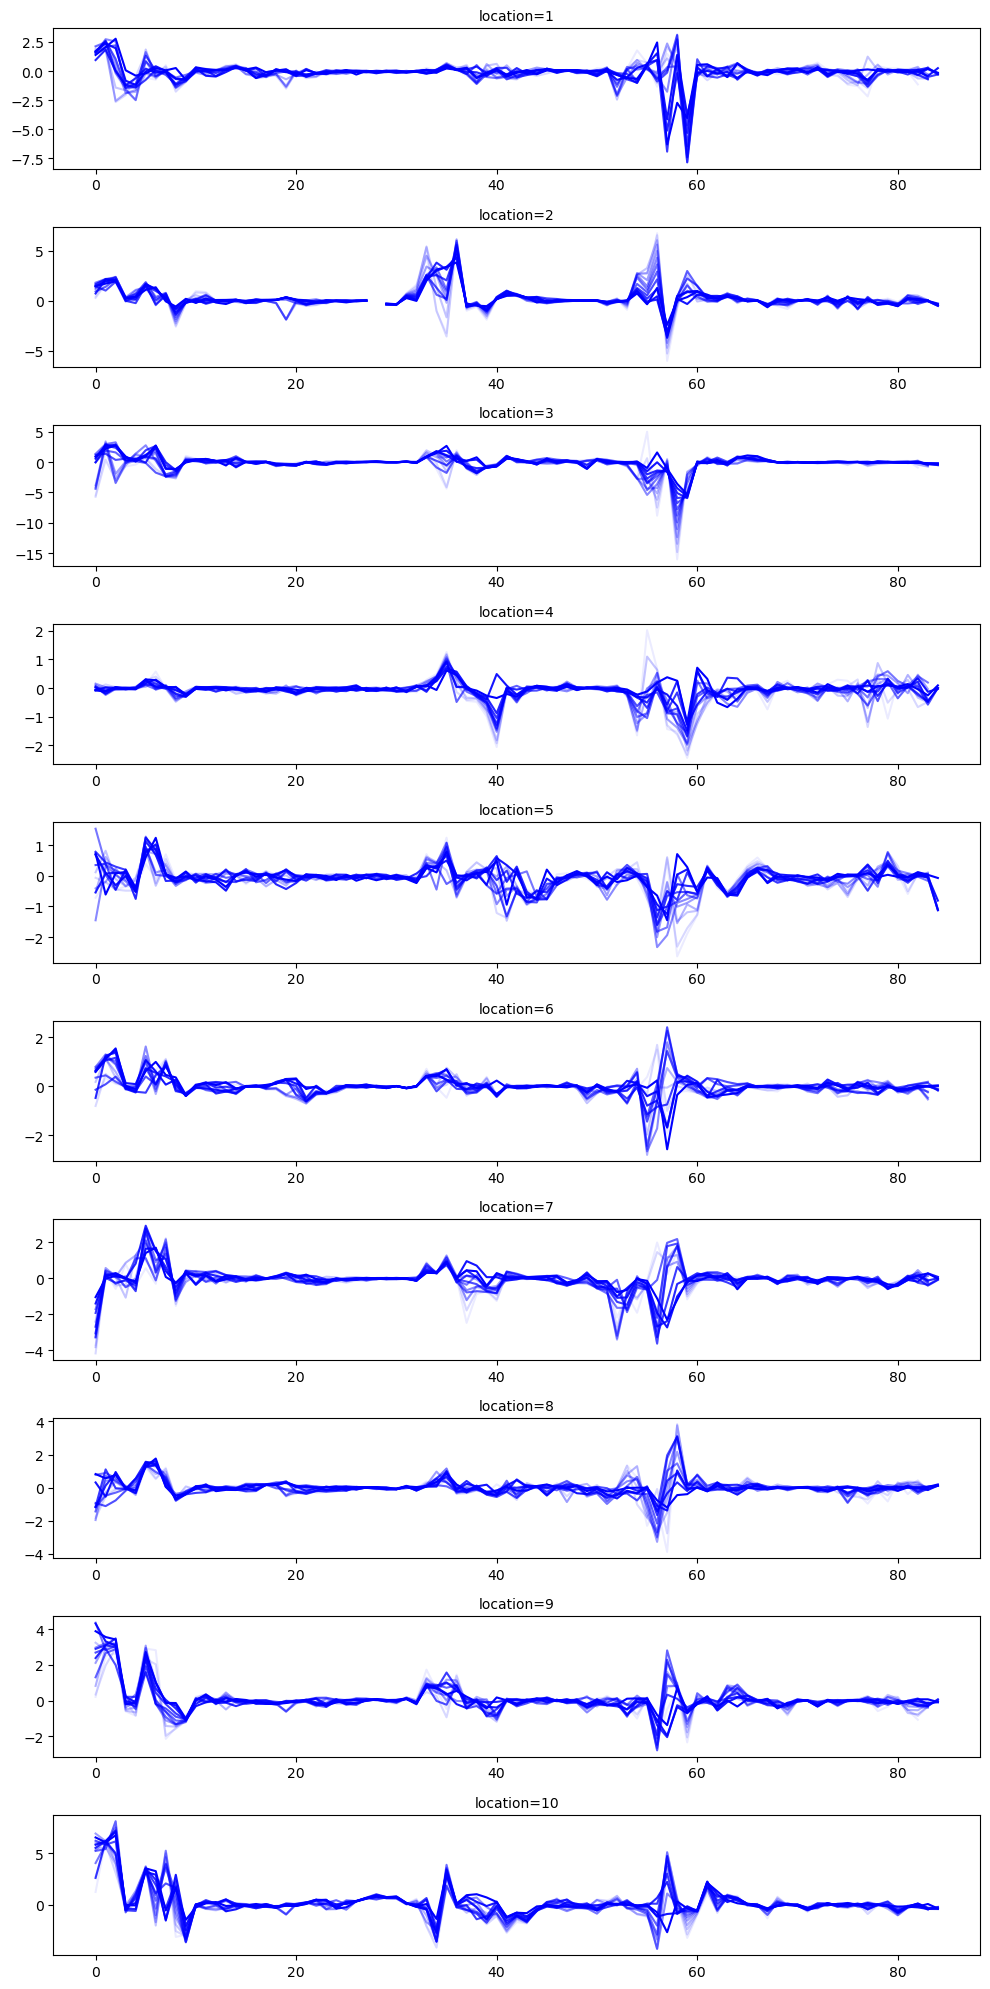

In [4]:
# Draw a real data
# Each row represents each location, color represents horizon 
mydata =loaddata("CU_select", "USC_SI_kJalpha", "diff_pop")

t=jnp.linspace(0, 84, 85)
fig, ax = plt.subplots(10, 1, figsize = (10, 20), squeeze=False)

for loc in range(10):
    for i in range(13):
        ax[loc, 0].plot(t, mydata[:,loc,i], alpha = 1-1/13*i, color = 'blue')
        ax[loc, 0].set_title('location='+str(loc+1), fontsize=10)

plt.tight_layout()

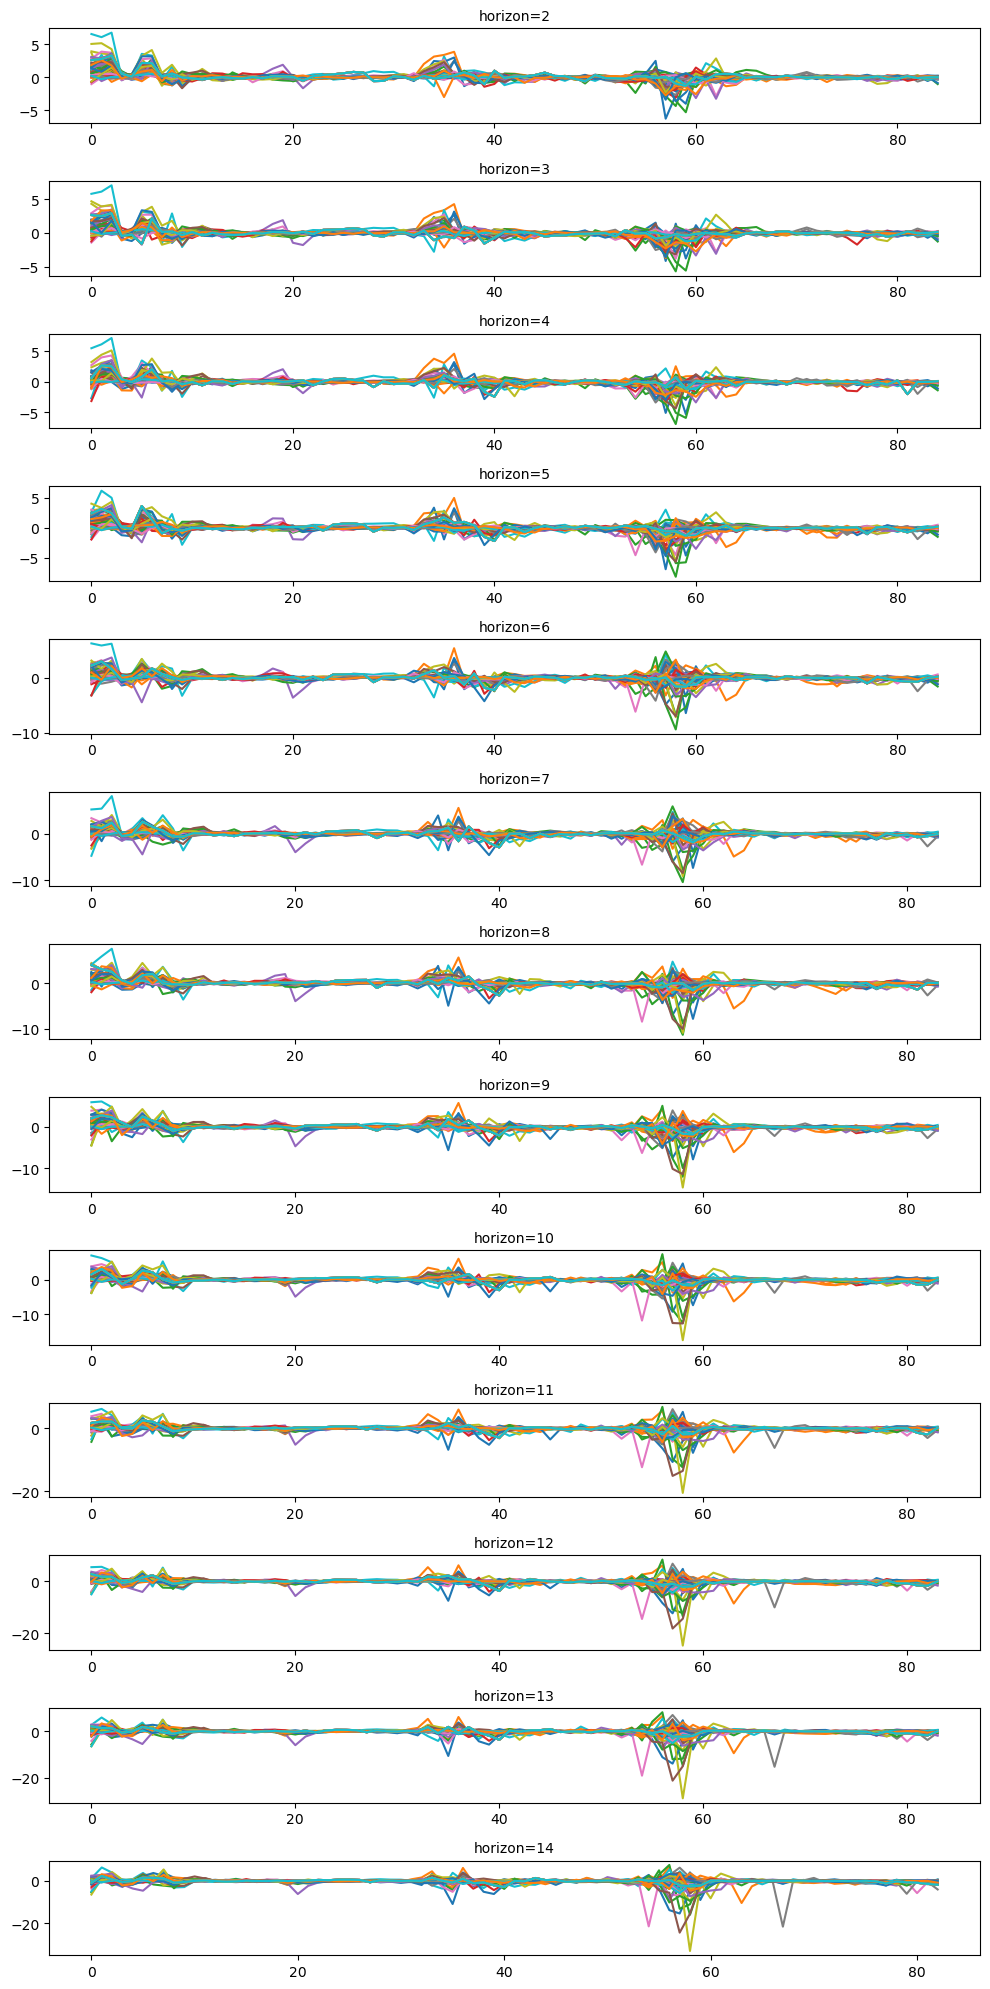

In [5]:
# Draw a real data
# Each row represents each horizon, color represents location
t=jnp.linspace(0, 84, 85)
fig, ax = plt.subplots(13, 1, figsize = (10, 20), squeeze=False)

for i in range(13):
    for loc in range(50):
        ax[i, 0].plot(t, mydata[:,loc,i])
        ax[i, 0].set_title('horizon='+str(i+2), fontsize=10)
plt.tight_layout()

### Handling missing observations
As a simple way, we just substitute 0 values to missing observation. However, we want to use the mask handler to mask invalid observed values (nans)  and not use that observations. (Added to archdfa.py)

In [5]:
mydata =loaddata("CU_select", "USC_SI_kJalpha", "diff")
#np.nan_to_num(mydata, nan=0)
ave_mydata = np.nanmean(mydata, axis=(1,2))
ave_mydata
_, DM_QS_stat, DM_QS_p, CBB_QS_p, opt_block, mean_d, V_d = CBB_test(ave_mydata,
                                                     seed = int(stochastic_function(1234)))

In [9]:
print(DM_QS_stat)
print(DM_QS_p)
print(CBB_QS_p)
print(opt_block)
print(mean_d)
print(V_d)
print(mean_d - DM_QS_stat*np.sqrt(V_d/len(ave_mydata)))
print(mean_d + DM_QS_stat*np.sqrt(V_d/len(ave_mydata)))

-0.6221995222941427
0.5354959656875085
0.6292
7
-3.0529082
2046.3836852957818
4.440892098500626e-16
-6.10581636428833


In [16]:
datalist = ["COVIDhub_4_week_ensemble", "COVIDhub_baseline", "CU_select"]

for combo in combinations(datalist, 2):
    print(combo[0])
    print(combo[1])

COVIDhub_4_week_ensemble
COVIDhub_baseline
COVIDhub_4_week_ensemble
CU_select
COVIDhub_baseline
CU_select


In [41]:
datalist = ["COVIDhub_4_week_ensemble", "COVIDhub_baseline"]

for combo in combinations(datalist, 2):
    realdata =loaddata(combo[0], combo[1], "diff_pop")
    ave_realdata = np.nanmean(realdata, axis=(1,2))

len(ave_realdata)

87

In [30]:
datalist = ["COVIDhub_4_week_ensemble", "COVIDhub_baseline", "CU_select", "GT_DeepCOVID", "JHUAPL_Bucky", "USC_SI_kJalpha"]

mean_d_all = []
V_d_all = []
DM_QS_stat_all = []
DM_QS_p_all = []
Boots_025percentile_all = []
Boots_975percentile_all = []
CBB_QS_p_all = []
T_all = []


for combo in combinations(datalist, 2):  # 2 for pairs, 3 for triplets, etc
    realdata =loaddata(combo[0], combo[1], "diff_pop")
    ave_realdata = np.nanmean(realdata, axis=(1,2))
    T = len(ave_realdata)
    print(T)

    CBB_stat, DM_QS_stat, DM_QS_p, CBB_QS_p, opt_block, mean_d, V_d = CBB_test(ave_realdata,
                                                     seed = int(stochastic_function(1234)))
    Boots_025percentile = np.quantile(CBB_stat, 0.025)
    Boots_975percentile = np.quantile(CBB_stat, 0.975)
    mean_d_all.append(mean_d)
    V_d_all.append(V_d)
    DM_QS_stat_all.append(DM_QS_stat)
    CBB_QS_p_all.append(CBB_QS_p)
    DM_QS_p_all.append(DM_QS_p)
    Boots_025percentile_all.append(Boots_025percentile)
    Boots_975percentile_all.append(Boots_975percentile)
    T_all.append(T)



87
84
87
87
86
84
87
87
86
93
93
85
96
88
88


In [31]:
CI_res = {'DM_QS_p_all' : DM_QS_p_all, 
          'DM_QS_stat_all' : DM_QS_stat_all, 
          'CBB_QS_p_all' : CBB_QS_p_all,
          'Boots_025percentile_all' : Boots_025percentile_all, 
          'Boots_975percentile_all' : Boots_975percentile_all, 
          'mean_d_all' : mean_d_all,
          'V_d_all' : V_d_all,
          'T_all' : T_all}

df = pd.DataFrame(CI_res)

# Save the DataFrame to a CSV file
df.to_csv('DM_diff_pop.csv', index=False) 

In [27]:
os.getcwd() 

'/Users/dongahkim/Creative Cloud Files/epi/comparing-forecasting-performance'

In [29]:
CI_res = np.c_[DM_QS_p_all, DM_QS_stat_all, low_CI_all, up_CI_all, mean_d_all]
file_path = 'DM_diff_pop.txt'

# Save the NumPy array to a text file
np.savetxt(file_path, CI_res, fmt='%f', delimiter='\t')

In [24]:
print(DM_QS_p_all)
print(DM_QS_stat_all)
print(low_CI_all)
print(up_CI_all)

[1.9495571389690008e-13, 0.0029240969500698094, 2.1397308166188346e-08, 2.9247358867070693e-06, 0.0016620921563240759, 0.5061879183822897, 0.28424014992383506, 0.42887261884010097, 0.41714259436907364, 0.3624878100385883, 0.08381173649348514, 0.2981569742014185, 0.6840513822639613, 0.644048489527554, 0.9617056181396497]
[-8.7063543429164, -3.0663924745300806, -6.172636956870645, -5.005720400085711, -3.248521929295708, 0.6676835387238268, -1.0775674988256516, -0.7948781537268247, -0.815364447498131, -0.9151835489598293, -1.7479336090003832, -1.0468821790814906, -0.4081918601957086, -0.46366115481882214, 0.048151816372165986]
[0.0018065598698860375, -0.0007069536087391942, 0.00206288302308702, 0.0022407087214837695, 0.0012266724473898039, 0.00018580202467081974, 0.00029929716685264673, 0.0004341487208813499, 0.00033830496853987785, 0.0017741664763559345, 0.0022596219757263017, -1.3877787807814457e-17, 0.0009627278523092996, 0.000533795678978554, -4.806239068072277e-05]
[-0.31071779401028

### For CBB Confidence Interval

In [21]:
datalist = ["COVIDhub_4_week_ensemble", "COVIDhub_baseline", "CU_select", "GT_DeepCOVID", "JHUAPL_Bucky", "USC_SI_kJalpha"]

realdata =loaddata("COVIDhub_4_week_ensemble", "COVIDhub_baseline", "diff")
ave_realdata = np.nanmean(realdata, axis=(1,2))
T = len(ave_realdata)
print(T)

CBB_stat, DM_QS_stat, DM_QS_p, CBB_QS_p, opt_block, mean_d, V_d = CBB_test(ave_realdata,
                                                    seed = int(stochastic_function(1234)))




87


In [24]:
print(np.quantile(CBB_stat, [0.025, 0.975]))


[-1.88623367  2.74511759]


In [18]:
# Load a real data
# Average the data over location and horizon
realdata =loaddata("CU_select", "USC_SI_kJalpha", "diff_pop")
ave_realdata = realdata.mean(axis=(1,2))
_, DM_QS_stat, DM_QS_p, CBB_QS_p, opt_block = CBB_test(ave_realdata,
                                                     seed = int(stochastic_function(1234)))

datalist = ["COVIDhub_4_week_ensemble", "COVIDhub_baseline", "CU_select", "GT_DeepCOVID", "JHUAPL_Bucky", "USC_SI_kJalpha"]



for combo in combinations(datalist, 2):  # 2 for pairs, 3 for triplets, etc
    realdata =loaddata(combo[0], combo[1], "diff_pop")
    ave_realdata = realdata.mean(axis=(1,2))
    boots_p_all = []
    DM_p_all = []
    for j in box_size:      
        _, boots_p, _, DM_p = Bootstrap_aSPA(ave_realdata, j)
        boots_p_all.append(boots_p)
    DM_p_all.append(DM_p)
  

DeviceArray([ 5.38741112e-01,  1.31312406e+00,  1.29091871e+00,
             -2.16111913e-01, -1.39114901e-01,  1.14182401e+00,
              5.62514424e-01,  4.21283841e-01, -5.47542512e-01,
             -1.86578050e-01,  1.01913542e-01,  1.15889452e-01,
              2.03872845e-02, -2.27609333e-02, -4.16049287e-02,
             -5.36719039e-02, -3.45389545e-02,  3.97081662e-04,
             -6.32180308e-04, -1.45723194e-01, -2.16892898e-01,
             -1.80285513e-01, -1.23651057e-01, -8.19197744e-02,
             -3.22800018e-02, -2.40573175e-02, -5.24810562e-03,
             -2.32607382e-03,             nan, -2.51001883e-02,
             -3.11516132e-02,  6.92927465e-03, -1.54854357e-02,
              5.23352027e-01,  2.58624554e-01,  3.21438134e-01,
              4.14638013e-01, -2.17599034e-01, -2.19896942e-01,
             -4.15061504e-01, -4.06515449e-01, -5.77067807e-02,
             -2.19854251e-01, -1.01664901e-01, -5.85875101e-02,
             -3.59540805e-02, -4.3066941

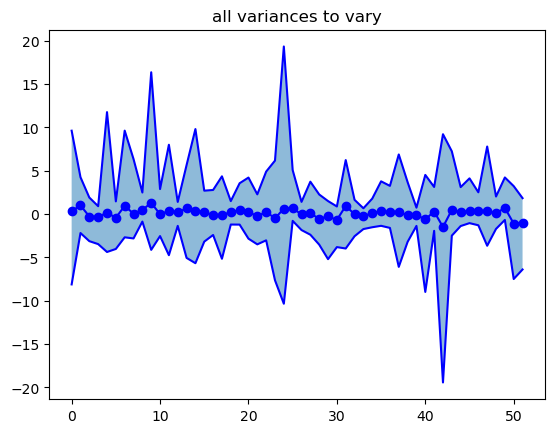

In [4]:
def aggregate_plot(y, axis1, title):
    
    mymean = y.mean(axis=axis1)
    mystd = y.std(axis=axis1)
    myupper = np.quantile(y, 0.975, axis=axis1)
    mylower = np.quantile(y, 0.025, axis=axis1)
    l=len(mymean)
    t=range(l)
    plt.plot(mymean, color = 'blue', marker='o')
    plt.plot(myupper, color = 'blue')
    plt.plot(mylower, color = 'blue')
    #plt.plot(mymean+mystd, color = 'blue')
    #plt.plot(mymean-mystd, color = 'blue')
    #plt.fill_between(t, mymean+mystd, mymean-mystd, alpha=0.5)
    plt.fill_between(t, myupper, mylower, alpha=0.5)
    plt.title(title)

        
aggregate_plot(sample_all_vary[2,:], axis1 = (1,2), title="all variances to vary")

In [5]:
def aggregate_plot_all(y_num, axis2, title):
    fig, ax = plt.subplots(1,5, figsize = (10, 6), squeeze=False)
    plt.subplot(3, 2, 1)
    aggregate_plot(sample_all_vary[y_num,:], axis1=axis2, title="all variances to vary")
    plt.subplot(3, 2, 2)
    aggregate_plot(sample_time_vary[y_num,:], axis1=axis2, title="time variance to vary")
    plt.subplot(3, 2, 3)
    aggregate_plot(sample_location_vary[y_num,:], axis1=axis2, title="location variance to vary")
    plt.subplot(3, 2, 4)
    aggregate_plot(sample_horizon_vary[y_num,:], axis1=axis2, title="horizon variance to vary")
    plt.subplot(3, 2, 5)
    aggregate_plot(sample_all_const[y_num,:], axis1=axis2, title="all variance constant")
    fig.suptitle(title)
    plt.tight_layout()

## DM and Bootstrap with conditioned data (1000 iterations and now CBB variance is DM_QS)
### open the data and aggregating by time

In [6]:
sample_size = 'small'
theta = 0.0

with open(f'simulation/ardfa_samples/{sample_size}_{theta}_all_vary.pkl', 'rb') as f:
                        obs = pickle.load(f)['y']
sample_all_vary = obs[0:200,:]
all_vary_mean_y = sample_all_vary.mean(axis=(2,3))

with open(f'simulation/ardfa_samples/{sample_size}_{theta}_sigma_t_vary.pkl', 'rb') as f:
                        obs = pickle.load(f)['y']
sample_time_vary = obs[0:200,:]
time_vary_mean_y = sample_time_vary.mean(axis=(2,3))


with open(f'simulation/ardfa_samples/{sample_size}_{theta}_sigma_l_vary.pkl', 'rb') as f:
                        obs = pickle.load(f)['y']
sample_location_vary = obs[0:200,:]
location_vary_mean_y = sample_location_vary.mean(axis=(2,3))

with open(f'simulation/ardfa_samples/{sample_size}_{theta}_sigma_h_vary.pkl', 'rb') as f:
                        obs = pickle.load(f)['y']
sample_horizon_vary = obs[0:200,:]
horizon_vary_mean_y = sample_horizon_vary.mean(axis=(2,3))

with open(f'simulation/ardfa_samples/{sample_size}_{theta}_all_constant.pkl', 'rb') as f:
                        obs = pickle.load(f)['y']
sample_all_const = obs[0:200,:]
all_const_mean_y = sample_all_const.mean(axis=(2,3))

In [7]:
d = all_vary_mean_y[1,]
HAC_Variance(d)

DeviceArray(0.5289285, dtype=float32)

In [8]:
print(dm_test(d, h = 1, kernel='False'))
print(dm_test(d, h = 1, kernel='QS'))

dm_return(DM=DeviceArray(-0.5480502, dtype=float32), p_value=0.5860483676831317)
dm_return(DM=DeviceArray(-0.45953178, dtype=float32), p_value=0.6478052350341823)


### DM and CBB test

In [9]:
stochastic_function(2)

array([837575])

In [17]:
sample_size = 'small'
theta = [0.0, 1.0, 10.0]
iter = 1000
for k in theta:
        print(k)
        for condition in ['all_vary', 'sigma_t_vary', 'sigma_l_vary', 'sigma_h_vary', 'all_constant']:
                print(condition)
                with open(f'simulation/ardfa_samples/{sample_size}_{k}_{condition}.pkl', 'rb') as f:
                        obs = pickle.load(f)['y']
                mean_y = obs.mean(axis=(2,3))
                DM_QS_p_all = []
                DM_QS_stat_all = []
                CBB_QS_p_all = []
                opt_block_all = []
                for i in range(iter):
                        
                        _, DM_QS_stat, DM_QS_p, CBB_QS_p, opt_block = CBB_test(mean_y[i,:],
                                                     seed = int(stochastic_function(i)))

                        DM_QS_p_all.append(DM_QS_p)
                        DM_QS_stat_all.append(DM_QS_stat)
                        CBB_QS_p_all.append(CBB_QS_p)
                        opt_block_all.append(opt_block)

                locals()["_".join(["DM_QS_p_all", str(int(k)), condition])] = np.asarray(DM_QS_p_all)
                del DM_QS_p_all
                locals()["_".join(["DM_QS_stat_all", str(int(k)), condition])] = np.asarray(DM_QS_stat_all)
                del DM_QS_stat_all
                locals()["_".join(["CBB_QS_p_all", str(int(k)), condition])] = np.asarray(CBB_QS_p_all)
                del CBB_QS_p_all
                locals()["_".join(["opt_block_all", str(int(k)), condition])] = np.asarray(opt_block_all)
                del opt_block_all
        #globals()[f'boots_p_all_{k}'] = boots_p_all

0.0
all_vary
sigma_t_vary
sigma_l_vary
sigma_h_vary
all_constant
1.0
all_vary


KeyboardInterrupt: 

In [29]:
print((DM_QS_p_all_0_all_vary < 0.05).mean())
print((DM_QS_p_all_0_sigma_t_vary < 0.05).mean())
print((DM_QS_p_all_0_sigma_l_vary < 0.05).mean())
print((DM_QS_p_all_0_sigma_h_vary < 0.05).mean())
print((DM_QS_p_all_0_all_constant < 0.05).mean())

0.122
0.159
0.147
0.117
0.156


In [30]:
print((CBB_QS_p_all_0_all_vary < 0.05).mean())
print((CBB_QS_p_all_0_sigma_t_vary < 0.05).mean())
print((CBB_QS_p_all_0_sigma_l_vary < 0.05).mean())
print((CBB_QS_p_all_0_sigma_h_vary < 0.05).mean())
print((CBB_QS_p_all_0_all_constant < 0.05).mean())

0.06
0.051
0.088
0.091
0.089


In [31]:
sample_size = 'small'
theta = [1.0, 10.0]
iter = 1000
for k in theta:
        print(k)
        for condition in ['all_vary', 'sigma_t_vary', 'sigma_l_vary', 'sigma_h_vary', 'all_constant']:
                print(condition)
                with open(f'simulation/ardfa_samples/{sample_size}_{k}_{condition}.pkl', 'rb') as f:
                        obs = pickle.load(f)['y']
                mean_y = obs.mean(axis=(2,3))
                DM_QS_p_all = []
                DM_QS_stat_all = []
                CBB_QS_p_all = []
                opt_block_all = []
                for i in range(iter):
                        
                        _, DM_QS_stat, DM_QS_p, CBB_QS_p, opt_block = CBB_test(mean_y[i,:],
                                                     seed = int(stochastic_function(i)))

                        DM_QS_p_all.append(DM_QS_p)
                        DM_QS_stat_all.append(DM_QS_stat)
                        CBB_QS_p_all.append(CBB_QS_p)
                        opt_block_all.append(opt_block)

                locals()["_".join(["DM_QS_p_all", str(int(k)), condition])] = np.asarray(DM_QS_p_all)
                del DM_QS_p_all
                locals()["_".join(["DM_QS_stat_all", str(int(k)), condition])] = np.asarray(DM_QS_stat_all)
                del DM_QS_stat_all
                locals()["_".join(["CBB_QS_p_all", str(int(k)), condition])] = np.asarray(CBB_QS_p_all)
                del CBB_QS_p_all
                locals()["_".join(["opt_block_all", str(int(k)), condition])] = np.asarray(opt_block_all)
                del opt_block_all
        #globals()[f'boots_p_all_{k}'] = boots_p_all

1.0
all_vary
sigma_t_vary
sigma_l_vary
sigma_h_vary
all_constant
10.0
all_vary
sigma_t_vary
sigma_l_vary
sigma_h_vary
all_constant


In [32]:
print((CBB_QS_p_all_1_all_vary < 0.05).mean())
print((CBB_QS_p_all_1_sigma_t_vary < 0.05).mean())
print((CBB_QS_p_all_1_sigma_l_vary < 0.05).mean())
print((CBB_QS_p_all_1_sigma_h_vary < 0.05).mean())
print((CBB_QS_p_all_1_all_constant < 0.05).mean())

0.743
0.805
0.944
0.929
0.948


In [33]:
print((CBB_QS_p_all_10_all_vary < 0.05).mean())
print((CBB_QS_p_all_10_sigma_t_vary < 0.05).mean())
print((CBB_QS_p_all_10_sigma_l_vary < 0.05).mean())
print((CBB_QS_p_all_10_sigma_h_vary < 0.05).mean())
print((CBB_QS_p_all_10_all_constant < 0.05).mean())

0.964
0.95
0.991
0.994
0.991


In [34]:
print((DM_QS_p_all_1_all_vary < 0.05).mean())
print((DM_QS_p_all_1_sigma_t_vary < 0.05).mean())
print((DM_QS_p_all_1_sigma_l_vary < 0.05).mean())
print((DM_QS_p_all_1_sigma_h_vary < 0.05).mean())
print((DM_QS_p_all_1_all_constant < 0.05).mean())

0.791
0.892
0.956
0.942
0.957


In [35]:
print((DM_QS_p_all_10_all_vary < 0.05).mean())
print((DM_QS_p_all_10_sigma_t_vary < 0.05).mean())
print((DM_QS_p_all_10_sigma_l_vary < 0.05).mean())
print((DM_QS_p_all_10_sigma_h_vary < 0.05).mean())
print((DM_QS_p_all_10_all_constant < 0.05).mean())

0.98
0.98
0.993
0.994
0.993


In [23]:
def CBBhistplot(data, i):
    CBB_stat, DM_QS_stat, DM_QS_p, CBB_QS_p, opt_block = CBB_test(data[i,:],
                                                    seed = int(stochastic_function(i)))
    if CBB_QS_p < 0.05:
        reject = "reject"
    else : reject = "Not reject"
    fig, ax = plt.subplots(1,3, figsize = (10, 2), squeeze=False)
    plt.subplot(1, 3, 1)
    plt.hist(CBB_stat, bins = 50)
    plt.axvline(x = DM_QS_stat, color = 'r')
    plt.axvline(x = - DM_QS_stat, color = 'r')
    plt.subplot(1, 3, 2)
    aggregate_plot(sample_all_vary[i,:], axis1=(1,2), title= f'all variances to vary_{reject}_{opt_block}')
    plt.subplot(1, 3, 3)
    plt.plot(data[i,:], color = 'blue', marker='o')  
    fig.suptitle(f'mean={round(data[i,:].mean(),2)}, var={round(data[i,:].var(),2)}')
    plt.tight_layout()

In [27]:
np.where(CBB_QS_p_all_0_all_constant<0.05)

(array([ 13,  24,  30,  37,  65,  89, 107, 112, 122, 142, 148, 193, 195,
        202, 210, 214, 221, 257, 259, 264, 278, 293, 298, 301, 302, 303,
        309, 315, 321, 333, 346, 383, 401, 406, 415, 435, 437, 439, 440,
        442, 455, 457, 494, 496, 500, 501, 513, 515, 525, 555, 561, 566,
        569, 578, 587, 588, 591, 598, 610, 636, 640, 642, 645, 665, 675,
        693, 696, 700, 708, 729, 738, 752, 768, 789, 797, 816, 846, 847,
        860, 901, 919, 938, 939, 943, 944, 947, 974, 989, 995]),)

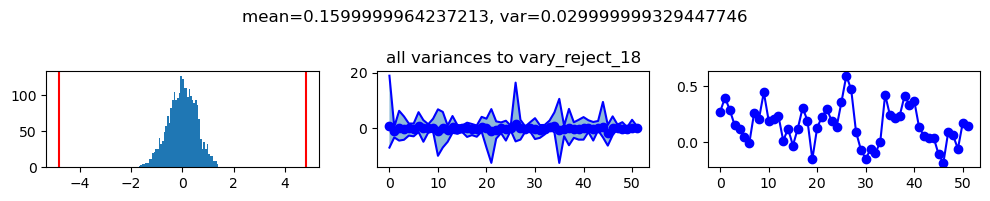

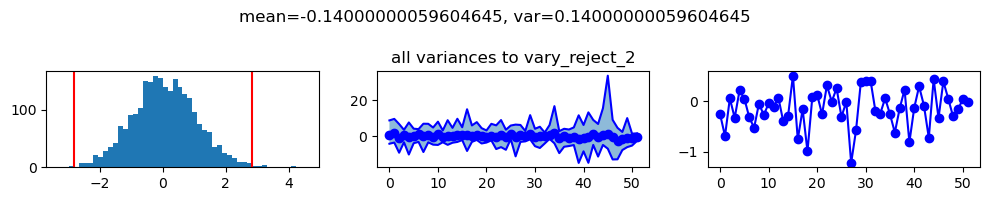

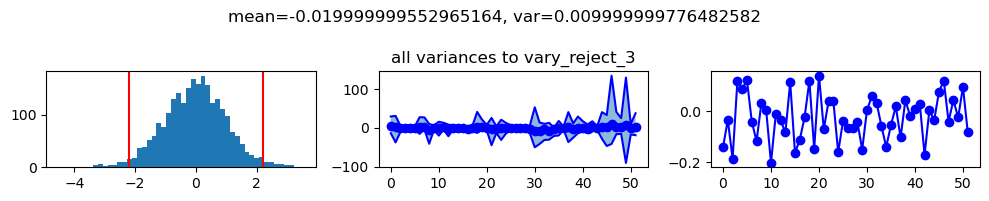

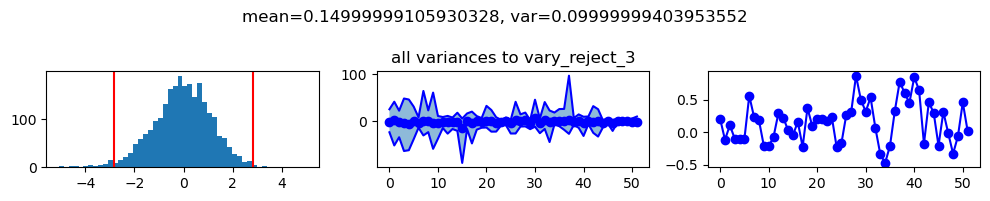

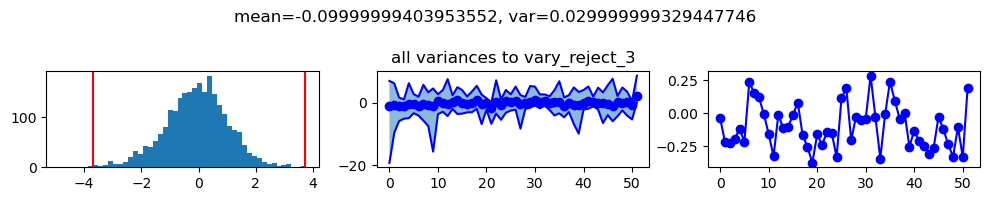

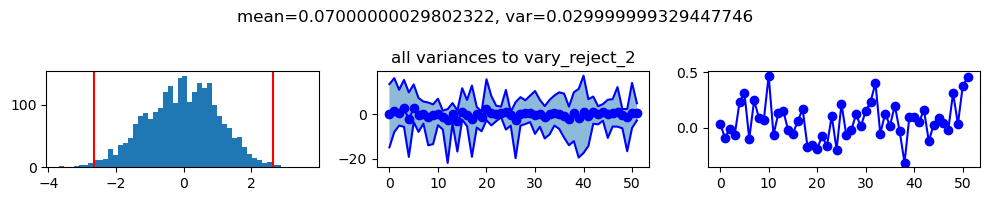

In [28]:
for i in [13,  24,  30,  37,  65,  89]: 
    CBBhistplot(all_const_mean_y, i = i)